# Classification model for BBC news

In [3]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Download the file with the BBC news and labels

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-10-04 18:38:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.204.16, 216.58.212.240, 216.58.205.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.204.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  4.37MB/s    in 1.1s    

2020-10-04 18:38:25 (4.37 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



### Set up hyperparameters

In [9]:
vocab_size = 10000 
embedding_dim = 16 
max_length = 120 
trunc_type = 'post' 
padding_type = 'post' 
oov_tok = "<OOV>" 
training_portion = .8

### Create arrays with sentences and labels

In [10]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


with open("/tmp/bbc-text.csv", 'r') as csvfile:
    data = csv.reader(csvfile)
    next(data) # Skips first line
    for row in data:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords: # Eliminate stop words
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
        sentences.append(sentence)

    
print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us s tivo uk s sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take off europe lack high-definition programming. not can people forward wind adverts can also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cab

### Divide into train/validation sets

In [11]:
train_size = int(training_portion*len(sentences))

train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:] 

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


### Tokenize and pad sentences

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(train_sentences) 
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Tokenize labels

In [14]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = label_tokenizer.texts_to_sequences(train_labels)
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)

### Turn sentences and labels into np.array

In [15]:
train_padded = np.array(train_padded)
training_label_seq = np.array(training_label_seq)
validation_padded = np.array(validation_padded)
validation_label_seq = np.array(validation_label_seq)

### Define Sequential model with Embedding and two dense layers

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 160,558
Trainable params: 160,558
Non-trainable params: 0
_________________________________________________________________


### Train model

In [18]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 1s - loss: 1.7732 - accuracy: 0.4921 - val_loss: 1.7474 - val_accuracy: 0.6292
Epoch 2/30
1780/1780 - 0s - loss: 1.7044 - accuracy: 0.7146 - val_loss: 1.6548 - val_accuracy: 0.7326
Epoch 3/30
1780/1780 - 0s - loss: 1.5785 - accuracy: 0.7500 - val_loss: 1.5111 - val_accuracy: 0.6966
Epoch 4/30
1780/1780 - 0s - loss: 1.3932 - accuracy: 0.7528 - val_loss: 1.3043 - val_accuracy: 0.7348
Epoch 5/30
1780/1780 - 0s - loss: 1.1192 - accuracy: 0.8247 - val_loss: 0.9953 - val_accuracy: 0.8427
Epoch 6/30
1780/1780 - 0s - loss: 0.7637 - accuracy: 0.9438 - val_loss: 0.6666 - val_accuracy: 0.8944
Epoch 7/30
1780/1780 - 0s - loss: 0.4544 - accuracy: 0.9815 - val_loss: 0.4410 - val_accuracy: 0.9483
Epoch 8/30
1780/1780 - 0s - loss: 0.2669 - accuracy: 0.9865 - val_loss: 0.3229 - val_accuracy: 0.9551
Epoch 9/30
1780/1780 - 0s - loss: 0.1671 - accuracy: 0.9899 - val_loss: 0.2633 - val_accuracy: 0.9528
Epoch 10/30
1780/1780 - 0s - loss: 

### Plot accuracy and loss function

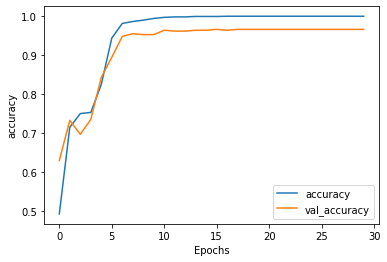

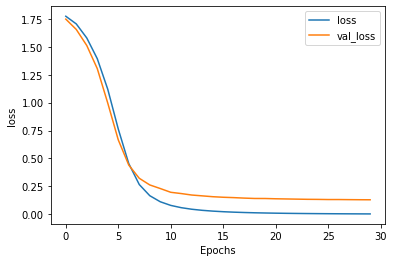

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Extra: Visualize embedding in http://projector.tensorflow.org/

The following code generates two files: 'vecs.tsv' and 'meta.tsv'. These files can be loaded into http://projector.tensorflow.org/ to visualize the embedding weights.

In [25]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


e = model.layers[0]
weights = e.get_weights()[0]

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(10000, 16)
